In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.optimize as opt
import numpy as np

%run ICMEmodelClass.py


# Что делаем?

<b> Постановка задачи:</b> есть трехслойниый симметричный волновод толщиной $d$, показатели преломления обкладок - $n_1, n_3$, сердцевины - $n_2$. В него попадает ЭМ волна с волновым числом $k$ и возбуждает 0ю моду. Ориентация кристалла -  ось 100 кристалла ориентирована под углом $\phi$ к проекции волнового вектора на плоскость ХУ, ось 001.

<b> Цель:</b>  получить зависимость поля ОЭКМ от параметров.

Большая часть поворотов, умножений, взятия производных матриц и тензоров была проделана в ВФ Математике, здесь будет решение модового уравнения и последующее построение графиков распределения полей в зависимости от значения параметров

вывод формул ОЭКМ в <code>waveguide ICME.nb</code> 




![shit](for_article/1x/7.png)

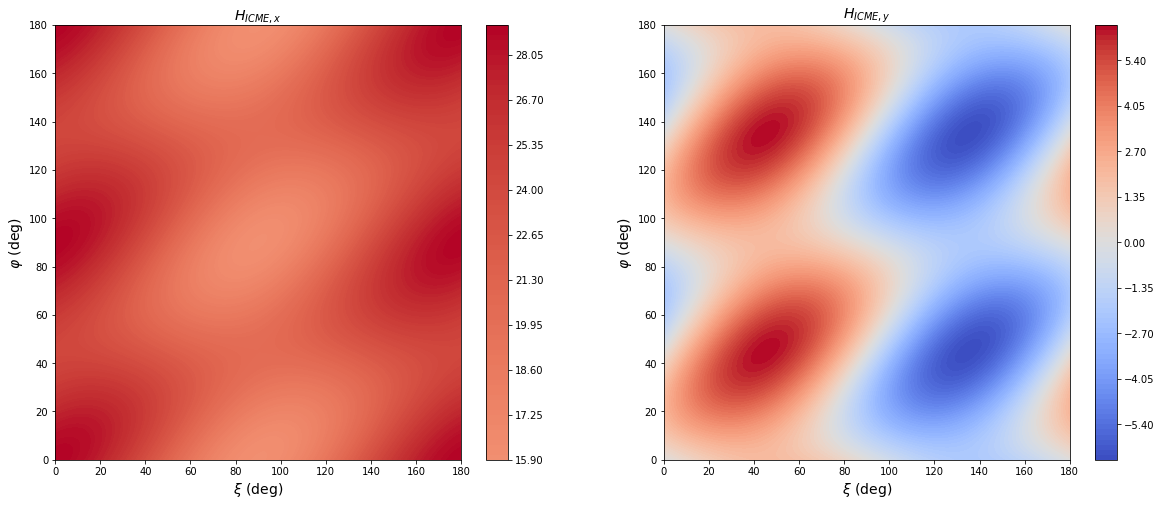

In [2]:
# for article picture
icme = ICMEmodel(0.3, 1, np.sqrt(5.5), 2)
psi = 0
PHI = np.linspace(0, np.pi, 200)
KSI = np.linspace(0, np.pi, 500)
icme_fields = np.zeros((200, 500, 3))

H = icme.get_H(1, psi,0)
for i, phi in enumerate(PHI):
    M = icme.get_M_from_H(H, phi)
    for j, ksi in enumerate(KSI):
    
        E = (np.cos(ksi), np.sin(ksi), 0)
        icme_fields[i, j, :] = icme.ICME_arbirtary_E(E, phi, M)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
cmap = plt.get_cmap(name='coolwarm')
ax[0].set_title(r'$H_{ICME, x}$', size=14)
ax[1].set_title(r'$H_{ICME, y}$', size=14)
for i in range(2):
    cf = ax[i].contourf(KSI/np.pi*180, PHI/np.pi*180, icme_fields[:,:,i],
                         100, cmap=cmap, norm=colors.CenteredNorm())
    fig.colorbar(cf, ax=ax[i])
    ax[i].set_xlabel(r'$\xi$ (deg)', size=14)
    ax[i].set_ylabel(r'$\varphi$ (deg)', size=14)


In [14]:
#compare light and modes
d = 0.3
n1 = 1
n2 = np.sqrt(5)
n3 = 2
icme = ICMEmodel(d, n1, n2, n3)
Psi = np.linspace(0, np.pi, 100)
Phi = np.linspace(0, np.pi, 100)
theta = 20/180*np.pi
lam = 1
beta_TE = icme.sol_mode_eq(lam, mode='TE')
beta_TM = icme.sol_mode_eq(lam, mode='TM')
Z = np.linspace(0, d, 100)
E_TE = icme.normalize_E(icme.get_E_field_TE(beta_TE, lam, 0))
E_TM = icme.normalize_E(icme.get_E_field_TM(beta_TE, lam, 0))
E_l_TE = icme.get_E(1, np.pi/2, 0)
E_l_TM = icme.get_E(1, 0, theta)
E_list = [E_TE, E_l_TE, E_TM, E_l_TM]

icmes = np.zeros((100, 100, 4, 3))

for i, psi in enumerate(Psi):
    H = icme.get_H(1, psi, theta)
    for j, phi in enumerate(Phi):
        M = icme.get_M_from_H(H, phi)

        for k in range(4):
            icmes[i, j, k, :] = icme.ICME_arbirtary_E(E_list[k], phi, M)

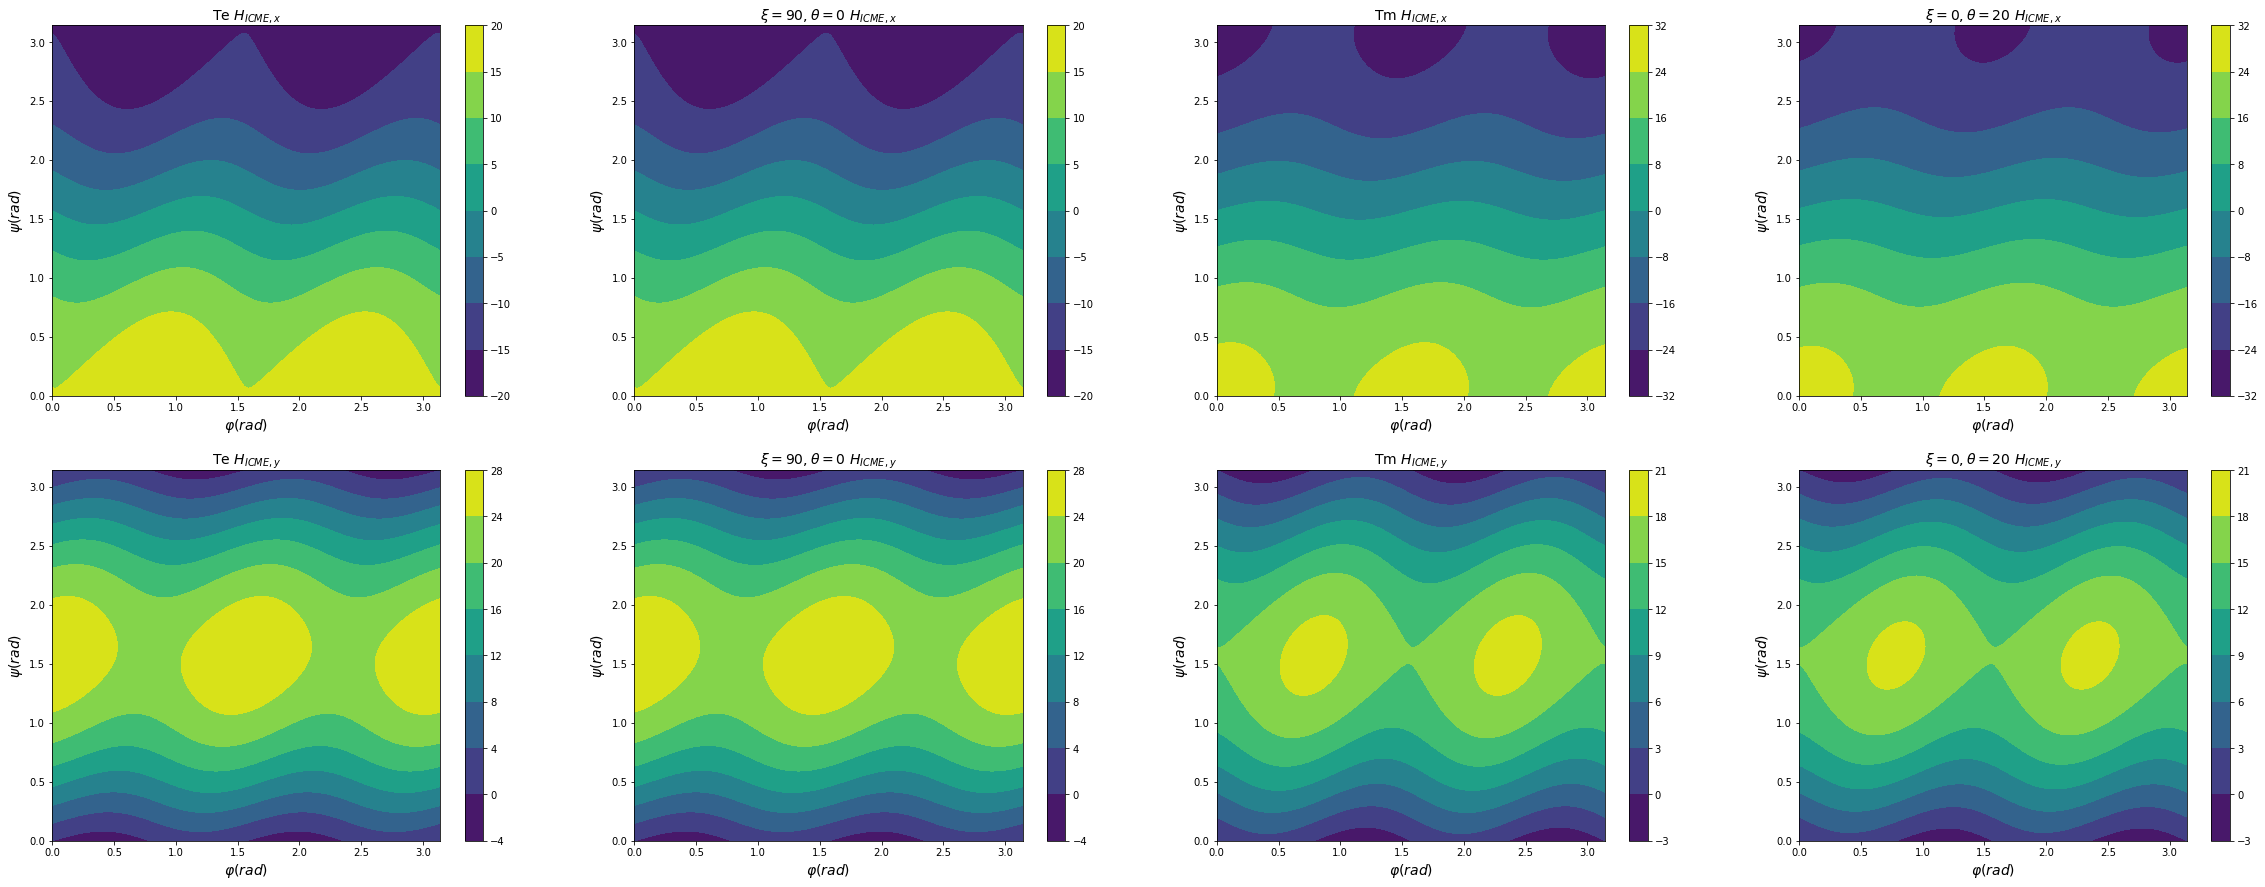

In [29]:
fig, ax = plt.subplots(2, 4, figsize=(40, 15))
titles = ['Te', r'$\xi=90, \theta=0$', 'Tm', r'$\xi=0, \theta=20$']
hs = ['$H_{ICME, x}$', '$H_{ICME, y}$']

for i in range(2):
    for j in range(4):
        ax[i][j].set_title(f"{titles[j]} {hs[i]}", size=14)
        cf = ax[i][j].contourf(Phi, Psi, icmes[:,:, j, i])
        fig.colorbar(cf, ax=ax[i][j])
        ax[i][j].set_xlabel(r'$\varphi (rad)$', size=14)
        ax[i][j].set_ylabel(r'$\psi (rad)$', size=14)

Text(0, 0.5, 'Shift')

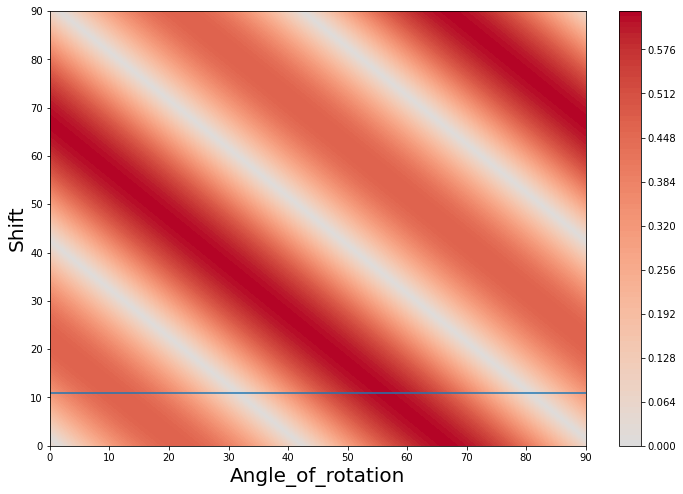

In [111]:
icme = ICMEmodel(0.3, 1, np.sqrt(5.5), 2)
a_o_r = np.linspace(0, np.pi/2, 200)
ksi = -np.pi*.01/2
shift = np.linspace(0, np.pi/2, 200)
psi = -np.pi/2
theta = np.pi*17/180
ans = []
for s in shift:
    tor = []
    for a in a_o_r:
        phi = (a+s)
        E = (np.cos(theta)*np.cos(ksi), np.sin(ksi), np.sin(theta)*np.cos(ksi))
        H = icme.get_H(1, psi, 0/180*np.pi)
        M = icme.get_M_from_H(H, phi)
        t = icme.get_icme_torque(E, H, M, phi)
        tor.append(np.abs(t[2]))
    ans.append(tor)

fig = plt.figure(figsize=(12, 8))

cmap = plt.get_cmap(name='coolwarm')
cf = plt.contourf(a_o_r/np.pi*180, shift/np.pi*180, ans, 100, cmap=cmap, norm=colors.CenteredNorm())
fig.colorbar(cf)
plt.plot(a_o_r/np.pi*180, [11]*a_o_r.shape[0])
plt.xlabel('Angle_of_rotation', size=20)
plt.ylabel('Shift', size=20)



Text(0.5, 0, 'Polarisation')

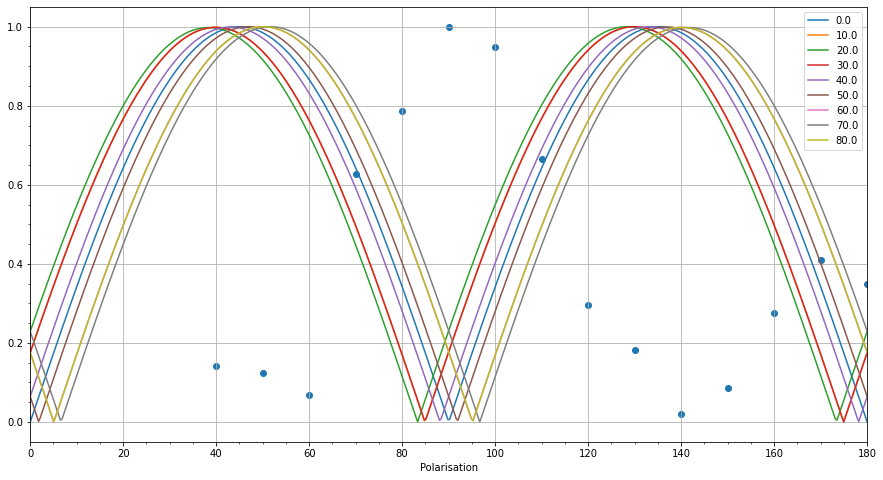

In [20]:
exp_x = [60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0, 200.0, 40.0, 50.0]
exp_y=[0.06862, 0.62801, 0.78781, 1.0, 0.94789, 0.66597, 0.29514, 0.18111, 0.01931,
 0.08727, 0.27654, 0.40941, 0.34795, 0.27092, 0.24837, 0.1426, 0.12521]

theta = 5.5/180*np.pi
plt.figure(figsize=(15, 8))
Ksi = np.linspace(0, np.pi, 500)
for i in range(0, 90, 10):
    tor = []
    phi = np.pi*i/180
    for ksi in Ksi:
        E = (np.cos(theta)*np.cos(ksi), np.sin(ksi), np.sin(theta)*np.cos(ksi))
        H = icme.get_H(1, -np.pi/2, 0/180*np.pi)
        M = icme.get_M_from_H(H, phi)
        t = icme.get_icme_torque(E, H, M, phi)
        tor.append(np.sqrt(t[1]**2 + t[2]**2))

    plt.plot((Ksi)/np.pi*180, (tor/np.max(tor)), label=str(phi/np.pi*180))
plt.scatter(np.array(exp_x), exp_y)
plt.xlim((0, 180))
plt.legend()
plt.minorticks_on()
plt.grid()
plt.xlabel('Polarisation')

100%|██████████| 90/90 [03:31<00:00,  2.35s/it]


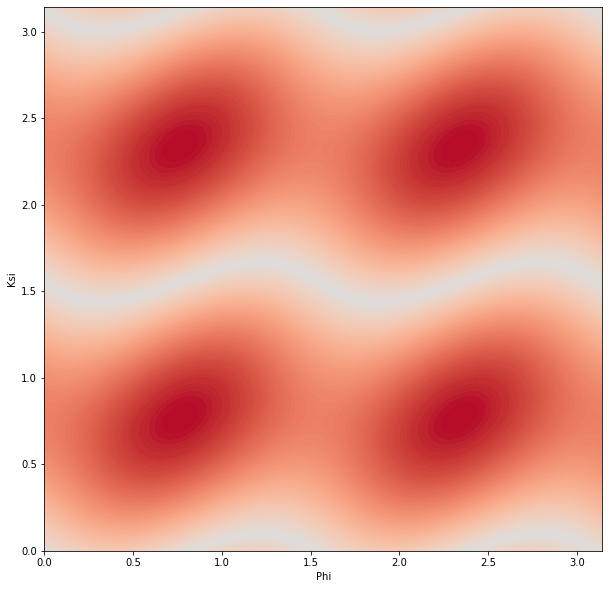

In [100]:
# Writing animation
import matplotlib
matplotlib.use("Agg")
from matplotlib.animation import FFMpegWriter
from tqdm import trange

metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

fig, ax = plt.subplots(figsize=(10, 10))
with writer.saving(fig, 'test.mp4', 100):

    icme = ICMEmodel(0.3, 1, np.sqrt(5.5), 2)
    lam = 0.885
    theta = 0/180*np.pi
    Ksi1 = np.linspace(0, np.pi, 100)
    Phi1 = np.linspace(0, np.pi, 100)
    torque1 = np.zeros((100, 100, 3))
    torque2 = np.zeros((100, 100, 3))
    for k in trange(90):
        for i, ksi in enumerate(Ksi1):
            for j, phi in enumerate(Phi1):
                E = (np.cos(theta)*np.cos(ksi), np.sin(ksi), np.sin(theta)*np.cos(ksi))
                H = icme.get_H(1, k/180*np.pi, 0/180*np.pi)
                M = icme.get_M_from_H(H, phi)
                torque1[i, j] = icme.get_icme_torque(E, H, M, phi)

        cf0 = ax.contourf(Phi1, Ksi1, np.sqrt(torque1[:,:,2]**2 + torque1[:,:,1]**2), 100, cmap=cmap, norm=colors.CenteredNorm())
        # fig.colorbar(cf0, ax=ax)
        ax.set_xlabel('Phi')
        ax.set_ylabel('Ksi')
        writer.grab_frame()

Text(0, 0.5, 'Ksi')

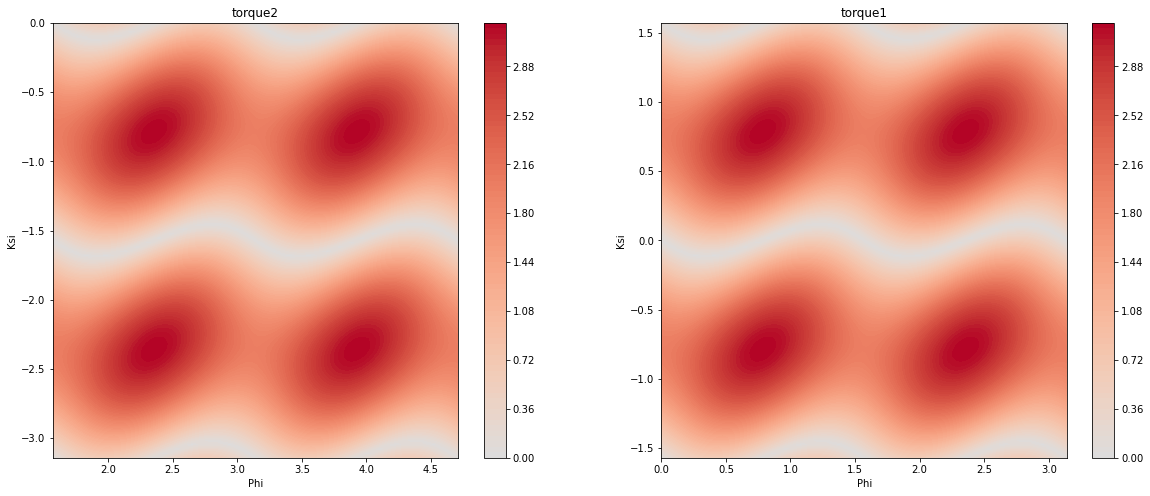

In [31]:
icme = ICMEmodel(0.3, 1, np.sqrt(5.5), 2)
theta = 0/180*np.pi
Ksi1 = np.linspace(-np.pi/2, np.pi/2, 100)
Phi1 = np.linspace(0, np.pi, 100)
Ksi2 = np.linspace(-np.pi, 0, 100)
Phi2 = np.linspace(np.pi/2, np.pi*3/2, 100)
torque1 = np.zeros((100, 100, 3))
torque2 = np.zeros((100, 100, 3))

for i, ksi in enumerate(Ksi1):
    for j, phi in enumerate(Phi1):
        E = (np.cos(theta)*np.cos(ksi), np.sin(ksi), np.sin(theta)*np.cos(ksi))
        H = icme.get_H(1, 0/180*np.pi, 0/180*np.pi)
        M = icme.get_M_from_H(H, phi)

        torque1[i, j] = icme.get_icme_torque(E, H, M, phi)
for i, ksi in enumerate(Ksi2):
    for j, phi in enumerate(Phi2):
        E = (np.cos(theta)*np.cos(ksi), np.sin(ksi), np.sin(theta)*np.cos(-ksi))
        H = icme.get_H(1, np.pi/2, 0/180*np.pi)
        M = icme.get_M_from_H(H, phi)

        torque2[i, j] = icme.get_icme_torque(E, H, M, phi)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
cmap = plt.get_cmap(name='coolwarm')

ax[1].set_title(f"torque1")
cf0 = ax[1].contourf(Phi1, Ksi1, np.sqrt(torque1[:,:,2]**2 + torque1[:,:,1]**2), 100, cmap=cmap, norm=colors.CenteredNorm())
fig.colorbar(cf0, ax=ax[1])
ax[1].set_xlabel('Phi')
ax[1].set_ylabel('Ksi')
ax[0].set_title(f"torque2")
cf0 = ax[0].contourf(Phi2, Ksi2, np.sqrt(torque2[:,:,2]**2 + torque2[:,:,1]**2), 100, cmap=cmap, norm=colors.CenteredNorm())
fig.colorbar(cf0, ax=ax[0])
ax[0].set_xlabel('Phi')
ax[0].set_ylabel('Ksi')

Text(0, 0.5, 'mode refractive index (beta/k0)')

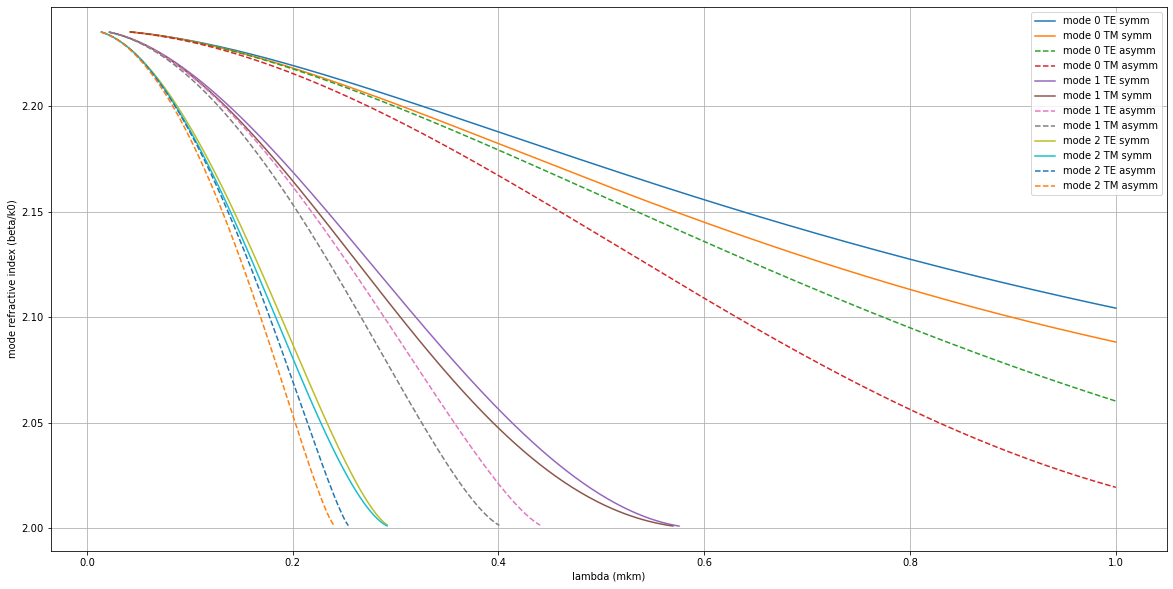

In [4]:
# In this block we will compute ICME torque for higher than 0 modes 

symm = ICMEmodel(0.3, 2, np.sqrt(5), 2)
asymm = ICMEmodel(0.3, 1, np.sqrt(5), 2)

Lam = np.linspace(0.01, 1, 500)

betas_symm_TE = [[symm.sol_mode_eq(l, N=i, mode='TE')*l/2/np.pi if symm.sol_mode_eq(l, N=i, mode='TE') !=None  else None for l in Lam] for i in range(3)]
betas_asymm_TE = [[asymm.sol_mode_eq(l, N=i, mode='TE')*l/2/np.pi if asymm.sol_mode_eq(l, N=i, mode='TE') !=None  else None for l in Lam] for i in range(3)]
betas_symm_TM = [[symm.sol_mode_eq(l, N=i, mode='TM')*l/2/np.pi if symm.sol_mode_eq(l, N=i, mode='TM') !=None  else None for l in Lam] for i in range(3)]
betas_asymm_TM = [[asymm.sol_mode_eq(l, N=i, mode='TM')*l/2/np.pi if asymm.sol_mode_eq(l, N=i, mode='TM') !=None  else None for l in Lam] for i in range(3)]

plt.figure(figsize=(20, 10))
for i in range(3):
    plt.plot(Lam, betas_symm_TE[i], label=f'mode {i} TE symm')
    plt.plot(Lam, betas_symm_TM[i], label=f'mode {i} TM symm')
    plt.plot(Lam, betas_asymm_TE[i], '--', label=f'mode {i} TE asymm')
    plt.plot(Lam, betas_asymm_TM[i], '--', label=f'mode {i} TM asymm')

plt.legend()
plt.grid()
plt.xlabel('lambda (mkm)')
plt.ylabel('mode refractive index (beta/k0)')

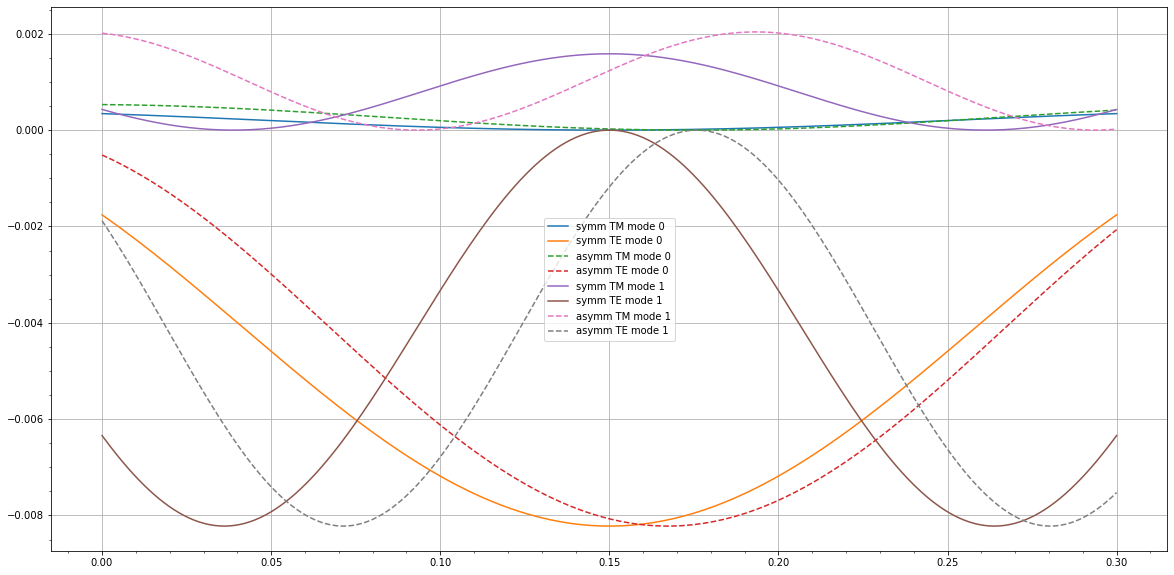

In [81]:
symm = ICMEmodel(0.3, 2, np.sqrt(5), 2)
asymm = ICMEmodel(0.3, 1, np.sqrt(5), 2)

lam = 0.4
Z = np.linspace(0, 0.3, 200)
psi = np.pi*5/180
out_of_plane = 0/180*np.pi
phi = 15/180*np.pi
H = ICMEmodel.get_H(1, psi, out_of_plane)
M = ICMEmodel.get_M_from_H(H, phi)

torqsTMsymm = []
torqsTEsymm = []
torqsTMasymm = []
torqsTEasymm = []
Modes = 2

for i in range(Modes):
    # torqsTMsymm.append(
    #     symm.normalize_E(symm.get_E_field_TM(symm.sol_mode_eq(lam, N=i, mode='TM'), lam, Z))[2])
    # torqsTEsymm.append(
    #     symm.normalize_E(symm.get_E_field_TE(symm.sol_mode_eq(lam, N=i, mode='TE'), lam, Z))[1])
    # torqsTMasymm.append(
    #     asymm.normalize_E(asymm.get_E_field_TM(asymm.sol_mode_eq(lam, N=i, mode='TM'), lam, Z))[2])
    # torqsTEasymm.append(
    #     asymm.normalize_E(asymm.get_E_field_TE(asymm.sol_mode_eq(lam, N=i, mode='TE'), lam, Z))[1])
    torqsTMsymm.append(symm.get_icme_torque(
        symm.normalize_E(symm.get_E_field_TM(symm.sol_mode_eq(lam, N=i, mode='TM'), lam, Z)),
        H, M, phi
    )[:, 2])
    torqsTEsymm.append(symm.get_icme_torque(
        symm.normalize_E(symm.get_E_field_TE(symm.sol_mode_eq(lam, N=i, mode='TE'), lam, Z)),
        H, M, phi
    )[:, 2])
    torqsTMasymm.append(asymm.get_icme_torque(
        asymm.normalize_E(asymm.get_E_field_TM(asymm.sol_mode_eq(lam, N=i, mode='TM'), lam, Z)),
        H, M, phi
    )[:, 2])
    torqsTEasymm.append(asymm.get_icme_torque(
        asymm.normalize_E(asymm.get_E_field_TE(asymm.sol_mode_eq(lam, N=i, mode='TE'), lam, Z)),
        H, M, phi
    )[:, 2])

plt.figure(figsize=(20, 10))
for i in range(Modes):
    plt.plot(Z, torqsTMsymm[i], label=f'symm TM mode {i}')
    plt.plot(Z, torqsTEsymm[i], label=f'symm TE mode {i}')
    plt.plot(Z, torqsTMasymm[i], '--', label=f'asymm TM mode {i}')
    plt.plot(Z, torqsTEasymm[i], '--', label=f'asymm TE mode {i}')
    # plt.plot(Z, torqsTMsymm[i]/np.max(np.abs(torqsTMsymm[i])), label=f'symm TM mode {i}')
    # plt.plot(Z, torqsTEsymm[i]/np.max(np.abs(torqsTEsymm[i])), label=f'symm TE mode {i}')
    # plt.plot(Z, torqsTMasymm[i]/np.max(np.abs(torqsTMasymm[i])), '--', label=f'asymm TM mode {i}')
    # plt.plot(Z, torqsTEasymm[i]/np.max(np.abs(torqsTEasymm[i])), '--', label=f'asymm TE mode {i}')
plt.legend()
plt.minorticks_on()
plt.grid()

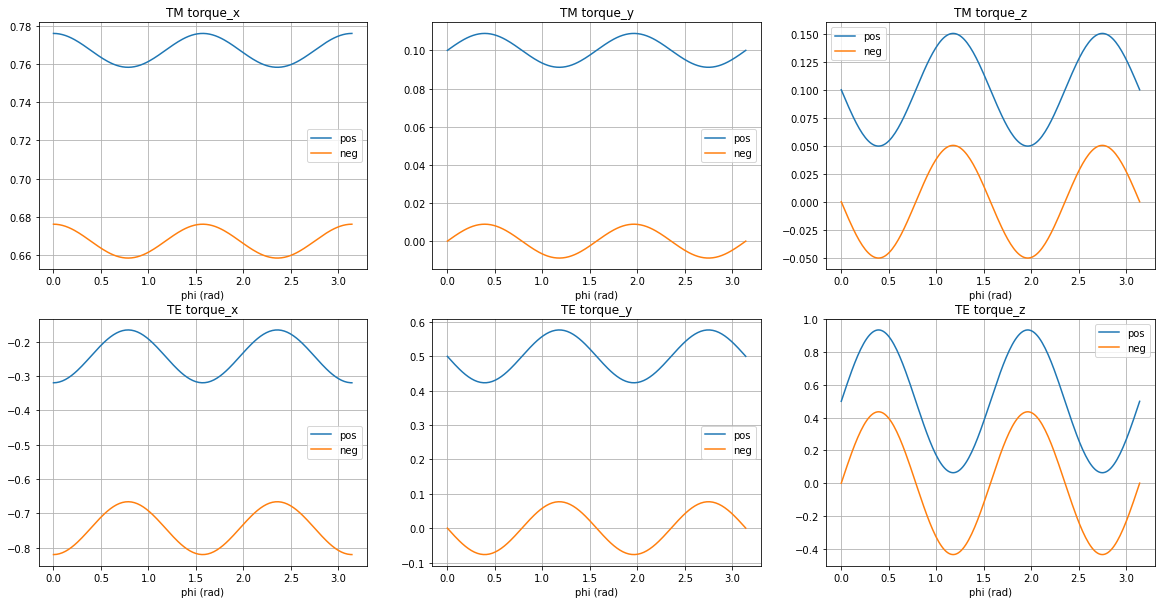

In [85]:
torque_pos_TM = np.zeros((3, 200))
torque_neg_TM = np.zeros((3, 200))
torque_pos_TE = np.zeros((3, 200))
torque_neg_TE = np.zeros((3, 200))
Phi = np.linspace(0, np.pi, 200)

psi = np.pi*90/180
out_of_plane = 10/180*np.pi
H_pos = asymm.get_H(1, psi, out_of_plane)
H_neg = asymm.get_H(-1, psi, out_of_plane)
lam = 1

beta_TM = asymm.sol_mode_eq(lam, N=0, mode='TM')
beta_TE = asymm.sol_mode_eq(lam, N=0, mode='TE')

for i, phi in enumerate(Phi):
    M_pos = asymm.get_M_from_H(H_pos, phi)
    M_neg = asymm.get_M_from_H(H_neg, phi)
    
    torque_pos_TM[:, i] = np.mean(asymm.get_icme_torque(
        asymm.normalize_E(asymm.get_E_field_TM(beta_TM, lam, Z)), H_pos, M_pos, phi), axis=0)
    torque_neg_TM[:, i] = np.mean(asymm.get_icme_torque(
        asymm.normalize_E(asymm.get_E_field_TM(beta_TM, lam, Z)), H_neg, M_neg, phi), axis=0)
    torque_pos_TE[:, i] = np.mean(asymm.get_icme_torque(
        asymm.normalize_E(asymm.get_E_field_TE(beta_TE, lam, Z)), H_pos, M_pos, phi), axis=0)
    torque_neg_TE[:, i] = np.mean(asymm.get_icme_torque(
        asymm.normalize_E(asymm.get_E_field_TE(beta_TE, lam, Z)), H_neg, M_neg, phi), axis=0)

fig, ax = plt.subplots(2, 3, figsize=(20, 10))
titles = ['x', 'y', 'z']

for i in range(3):
    ax[0][i].set_title(f"TM torque_{titles[i]}")
    ax[0][i].plot(Phi, 0.1+torque_pos_TM[i,:], label='pos')
    ax[0][i].plot(Phi, torque_neg_TM[i,:], label='neg')
    ax[0][i].set_xlabel('phi (rad)')
    ax[0][i].legend()
    ax[0][i].grid()

    ax[1][i].set_title(f"TE torque_{titles[i]}")
    ax[1][i].plot(Phi, 0.5+torque_pos_TE[i,:], label='pos')
    ax[1][i].plot(Phi, torque_neg_TE[i,:], label='neg')
    ax[1][i].set_xlabel('phi (rad)')
    ax[1][i].legend()
    ax[1][i].grid()

Добавим новый функционал. Прошлый блок был с кодом, который олицетворял решение задачи. Теперь пойдем дальше, у нас есть экспреимент в котором мы не можем менять именно эти углы, эти углы удобны для математического описания. В геометрии установки этип углы так просто не настроить. Начнем с того что в решетке (в которой мы планируем эту моду возбуждать) при фиксированной длине волны не при всяком угле $\phi$(по физическому смыслу это угол между осью 100 вектором распространения моды $\beta$) у нас будет возникать мода. Теперь мы будем дополнительно проверять условие возникновения моды, все новые углы и их смысл отображены на рисунке

![qasd](1x/1.png)